# Random Forests for Image Approximation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

# 2a. Load Image

Text(0.5, 1.0, 'Mona Lisa')

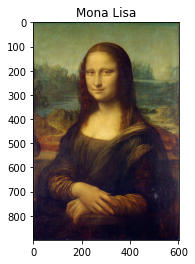

In [2]:
ml = plt.imread('Mona_Lisa.jpeg')
plt.imshow(ml)
plt.title('Mona Lisa')

In [3]:
ml.shape

(900, 604, 3)

# 2b. Preprocessing Input

In [4]:
height, width = ml.shape[0], ml.shape[1]

In [5]:
x_samples = np.random.choice(width, size=5000, replace=True)
y_samples = np.random.choice(height, size=5000, replace=True)

# 2c. Preprocessing Output

Convert image to grayscale and then sample pixel values at each of the coordinate locations from 2b. 

Note that I rescale the pixel values to be between 0.0 and 1.0 while plotting the images

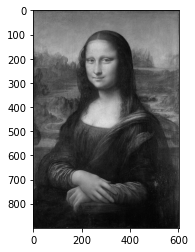

In [6]:
rgb_weights = [0.2989, 0.5870, 0.1140]
ml_gray = np.dot(ml[...,:3], rgb_weights)
plt.imshow(ml_gray, cmap='gray')

In [7]:
ml_gray.shape

(900, 604)

In [8]:
sample_viz = np.zeros([height, width, 1]) + 255

In [9]:
sample_viz.shape

(900, 604, 1)

In [10]:
x_samples.shape

(5000,)

In [11]:
y_samples.shape

(5000,)

In [12]:
pixels_sample = []
for x, y in zip(x_samples, y_samples):
    pixels_sample.append(ml_gray[y,x])
    sample_viz[y,x] = ml_gray[y,x]

Text(0.5, 1.0, 'Mona Lisa training set - 5000 uniformly sampled pixels')

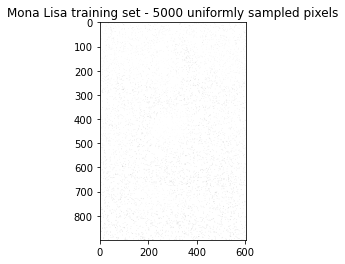

In [13]:
plt.imshow(sample_viz/255, cmap='gray')
plt.title('Mona Lisa training set - 5000 uniformly sampled pixels')

# 2d. Build Image Using Random Forest Regressor

I used sklearn's implementation of Random Forest Regressor: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html 

In [14]:
coordinates = np.array([y_samples, x_samples]).T

In [15]:
all_pixel_coords = []
for i in range(height):
    for j in range (width):
        all_pixel_coords.append((i,j))

In [16]:
def rf_reg(n_estimators = 10, max_depth = None, min_samples_split = 2, min_samples_leaf = 1, ccp_alpha=0.0, max_samples = None):
    rf = RandomForestRegressor(n_estimators = n_estimators, max_depth = max_depth, 
                               min_samples_split = min_samples_split, min_samples_leaf = min_samples_leaf,
                              ccp_alpha = ccp_alpha, max_samples = max_samples) 
    rf.fit(coordinates, pixels_sample)
    predicted = rf.predict(all_pixel_coords)
    return predicted/255

In [17]:
ml_rf = rf_reg(n_estimators = 1)

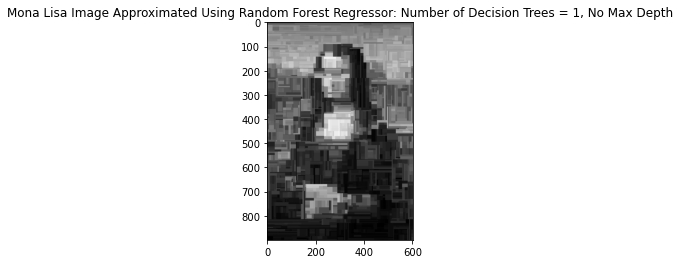

In [18]:
plt.imshow((ml_rf).reshape(height, width), cmap='gray')
plt.title('Mona Lisa Image Approximated Using Random Forest Regressor: Number of Decision Trees = 1, No Max Depth')
plt.show()

# 2e. Experimentation

## i. Single decision tree, varying depths

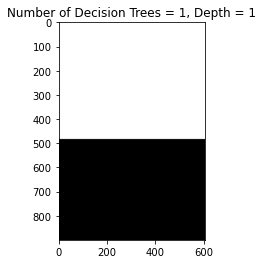

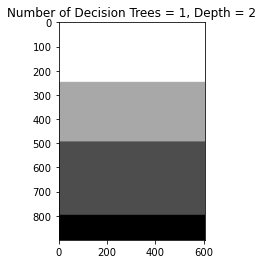

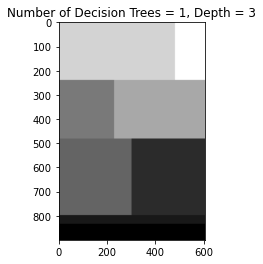

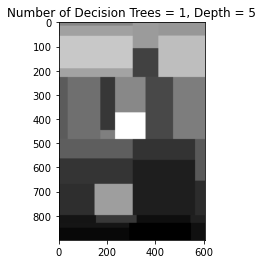

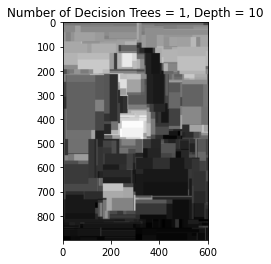

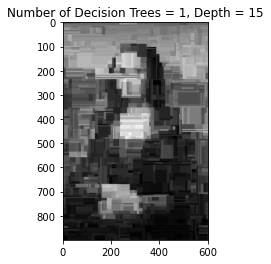

In [19]:
for i in [1, 2, 3, 5, 10, 15]:
    ml_rf_depth = rf_reg(n_estimators = 1, max_depth = i)
    plt.imshow((ml_rf_depth).reshape(height, width), cmap='gray')
    plt.title('Number of Decision Trees = 1, Depth = ' + str(i))
    plt.show()

## ii. Varying number of trees, fixed depth

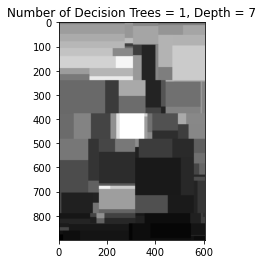

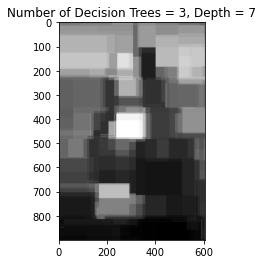

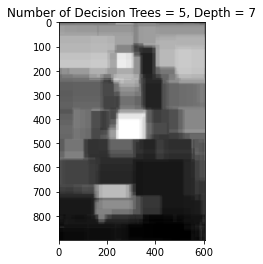

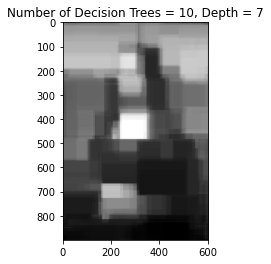

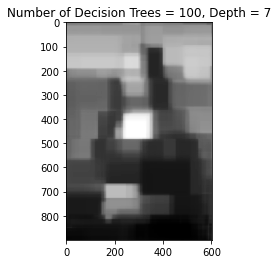

In [20]:
for i in [1, 3, 5, 10, 100]:
    ml_rf_trees = rf_reg(n_estimators = i, max_depth = 7)
    plt.imshow((ml_rf_trees).reshape(height, width), cmap='gray')
    plt.title('Number of Decision Trees = ' + str(i) + ', Depth = 7')
    plt.show()

## iii. k-NN Regressor (k = 1)

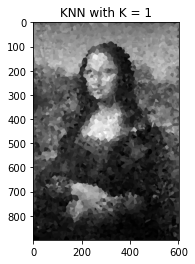

In [21]:
knn = KNeighborsRegressor(n_neighbors=1)
knn.fit(coordinates, pixels_sample)
predicted_knn = knn.predict(all_pixel_coords)
plt.imshow((predicted_knn/255).reshape(height, width), cmap='gray')
plt.title('KNN with K = 1')
plt.show()

## iv. Pruning strategies

### 1) Try different values for min_samples_split 

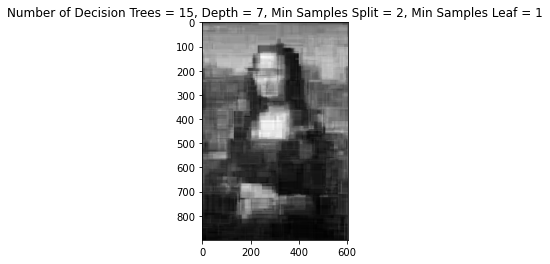

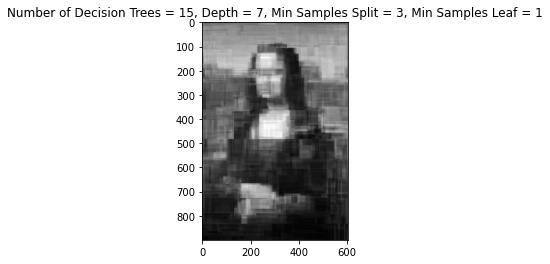

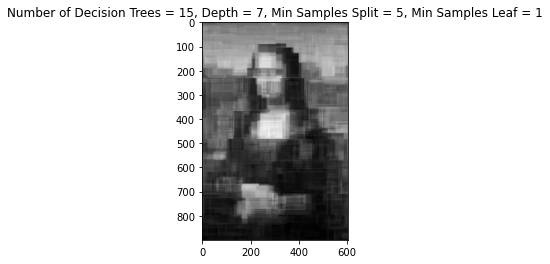

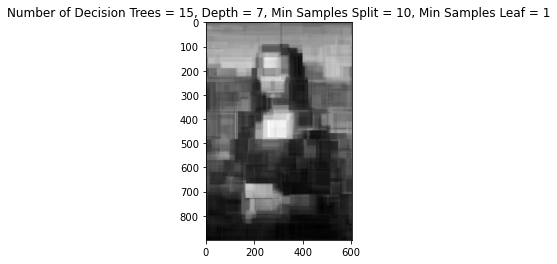

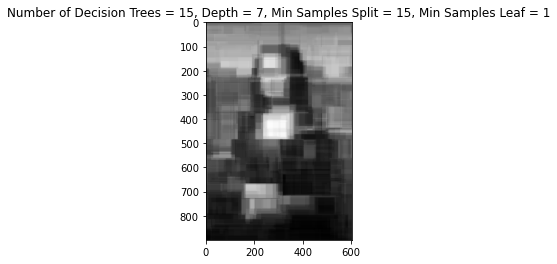

In [22]:
for i in [2, 3, 5, 10, 15]:
    ml_rf_split = rf_reg(n_estimators = 5, max_depth = 15, min_samples_split = i, min_samples_leaf = 1)
    plt.imshow((ml_rf_split).reshape(height, width), cmap='gray')
    plt.title('Number of Decision Trees = 15, Depth = 7, Min Samples Split = ' + str(i) + 
              ', Min Samples Leaf = 1')
    plt.show()

### 2) Try different values for min_samples_leaf 

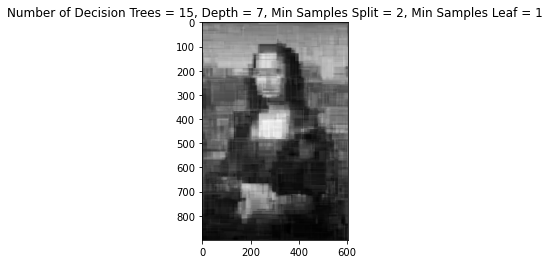

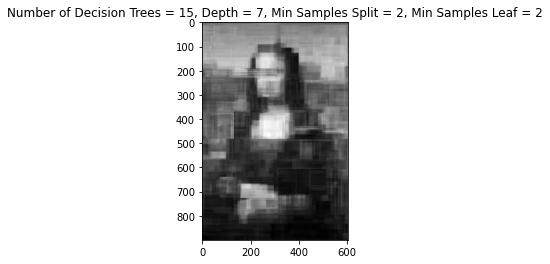

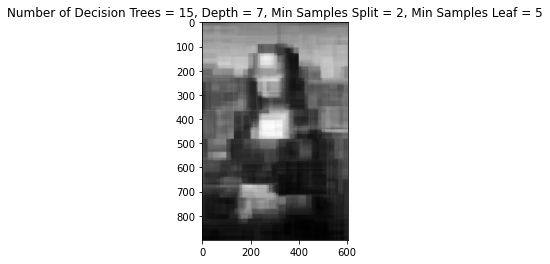

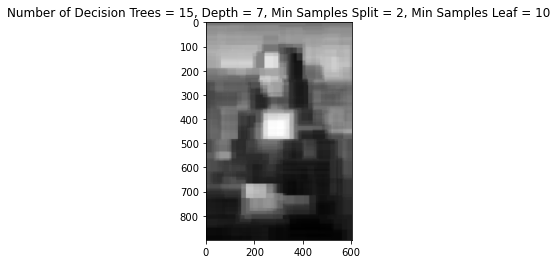

In [23]:
for i in [1, 2, 5, 10]:
    ml_rf_leaf = rf_reg(n_estimators = 5, max_depth = 15, min_samples_split = 2, min_samples_leaf = i)
    plt.imshow((ml_rf_leaf).reshape(height, width), cmap='gray')
    plt.title('Number of Decision Trees = 15, Depth = 7, Min Samples Split = 2, Min Samples Leaf = ' + str(i))
    plt.show()

### 3) Try different values for ccp_alpha

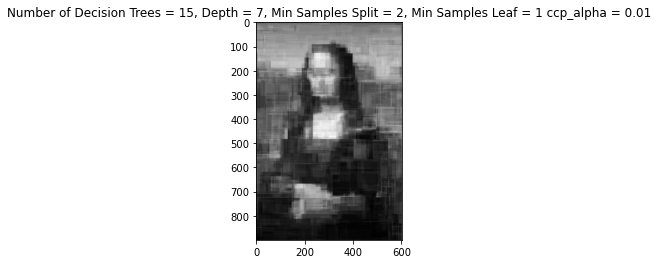

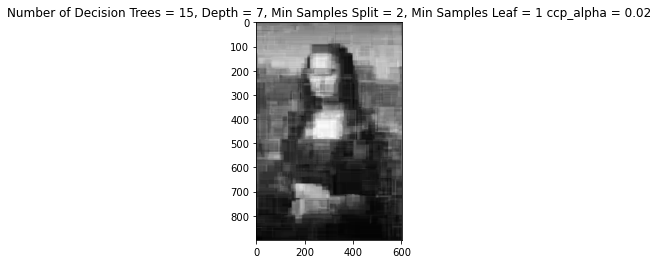

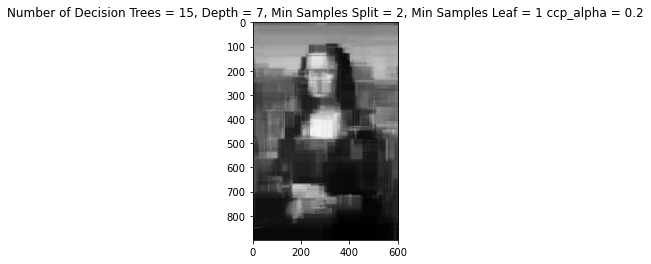

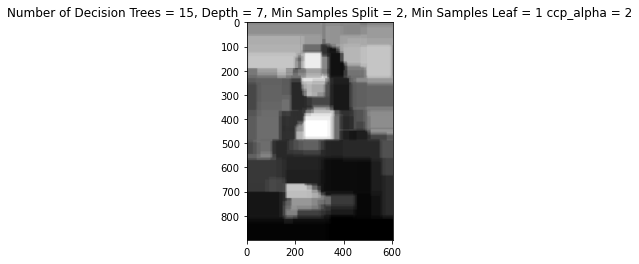

In [24]:
for i in [0.01, 0.02, 0.2, 2]:
    ml_rf_ccp = rf_reg(n_estimators = 5, max_depth = 15, min_samples_split = 2, min_samples_leaf = 1, 
                         ccp_alpha = i)
    plt.imshow((ml_rf_ccp).reshape(height, width), cmap='gray')
    plt.title('Number of Decision Trees = 15, Depth = 7, Min Samples Split = 2, Min Samples Leaf = 1 ' + 
              'ccp_alpha = ' + str(i))
    plt.show()

### 4) Try different values for max_sample

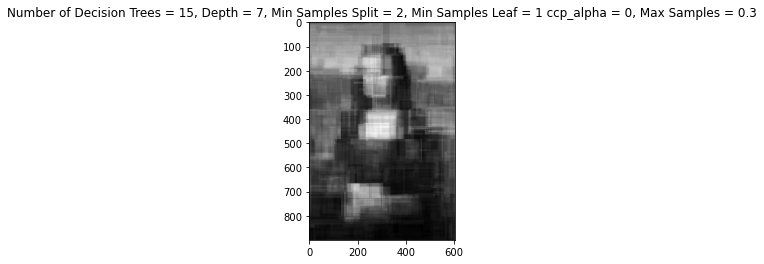

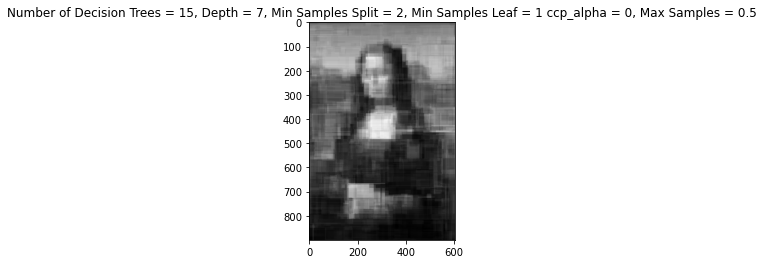

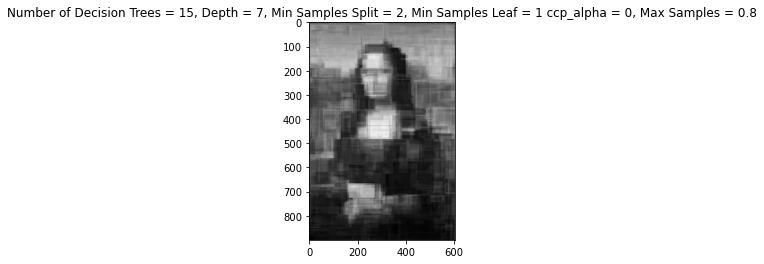

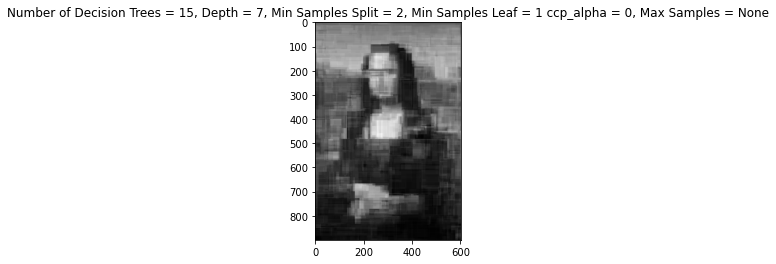

In [25]:
for i in [0.3, 0.5, 0.8, None]:
    ml_rf_samples = rf_reg(n_estimators = 5, max_depth = 15, min_samples_split = 2, min_samples_leaf = 1, 
                         ccp_alpha = 0.0, max_samples = i)
    plt.imshow((ml_rf_samples).reshape(height, width), cmap='gray')
    plt.title('Number of Decision Trees = 15, Depth = 7, Min Samples Split = 2, Min Samples Leaf = 1 ' + 
              'ccp_alpha = 0, Max Samples = ' + str(i))
    plt.show()

# 2f. Analysis

## i. Decision rule

In [42]:
import sklearn.tree as tree
from sklearn.tree import export_text

rf = RandomForestRegressor(n_estimators=2, max_depth=3)
rf_fit = rf.fit(coordinates, pixels_sample)
r = tree.export_text(rf_fit.estimators_[0])
print(r)

|--- feature_0 <= 482.50
|   |--- feature_0 <= 230.50
|   |   |--- feature_1 <= 489.50
|   |   |   |--- value: [116.56]
|   |   |--- feature_1 >  489.50
|   |   |   |--- value: [136.18]
|   |--- feature_0 >  230.50
|   |   |--- feature_0 <= 351.50
|   |   |   |--- value: [76.06]
|   |   |--- feature_0 >  351.50
|   |   |   |--- value: [96.73]
|--- feature_0 >  482.50
|   |--- feature_0 <= 812.50
|   |   |--- feature_1 <= 305.50
|   |   |   |--- value: [62.03]
|   |   |--- feature_1 >  305.50
|   |   |   |--- value: [33.23]
|   |--- feature_0 >  812.50
|   |   |--- feature_1 <= 587.50
|   |   |   |--- value: [14.98]
|   |   |--- feature_1 >  587.50
|   |   |   |--- value: [37.23]

